In [1]:
import pandas as pd

data = pd.read_csv("labeled_data.csv", encoding = "ISO-8859-1")

sentences = data["tweet"]
sentiments = data["sentiment"]

data.head(2)

,Unnamed: 0,id,created_at,date,time,timezone,user_id,username,name,tweet,language,link,retweet,sentiment
0,1439,1.520000e+18,2022-05-05 07:38:56 Turkey Standard Time,5/5/2022,7:38:56,300,1.230000e+18,mayank_twts,Mayank Verma,EdTech Startup ÃÂ¢ÃÂÃÂ The industry that...,en,https://twitter.com/mayank_twts/status/1522073...,False,1
1,726,1.520000e+18,2022-05-03 22:50:03 Turkey Standard Time,5/3/2022,22:50:03,300,9.260000e+17,huntingtonngc,Huntington Learning,There are a lot of unknowns about this school ...,en,https://twitter.com/HuntingtonNGC/status/15215...,False,0


In [2]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

sentence_all = list()
lines = sentences.to_list()

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if not w in stop_words]
    sentence_all.append(words)

print(sentence_all[0])

['edtech', 'startup', 'industry', 'gained', 'attention', 'uncertain', 'times', 'education', 'industry', 'students', 'teachers', 'feel', 'burned', 'pandemic', 'learning', 'companies', 'market', 'online', 'learning', 'tools', 'schools', 'enjoying', 'coronavirus', 'windfall']


In [3]:
import gensim

embedding_dim = 50
model = gensim.models.Word2Vec(sentences=sentence_all,vector_size=embedding_dim,window=5,workers=4,min_count=1)
words = len(model.wv)
print("Vocabulary size: %d"%(words))
model.wv.save_word2vec_format("embed.txt",binary=False)

Vocabulary size: 9053


In [4]:
import os
import numpy as np

embedding_index = {}
f = open(os.path.join('',"embed.txt"))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs

f.close()

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence_all)

sentences = tokenizer.texts_to_sequences(sentence_all)

word_index = tokenizer.word_index
print("Unique tokens:%d"%len(word_index))
print(sentence_all[0])
print(sentences[0])

Unique tokens:9053
['edtech', 'startup', 'industry', 'gained', 'attention', 'uncertain', 'times', 'education', 'industry', 'students', 'teachers', 'feel', 'burned', 'pandemic', 'learning', 'companies', 'market', 'online', 'learning', 'tools', 'schools', 'enjoying', 'coronavirus', 'windfall']
[49, 3777, 248, 1737, 1389, 2401, 317, 4, 248, 8, 21, 1390, 3778, 11, 2, 1142, 508, 5, 2, 561, 19, 2402, 7, 3779]


In [6]:
from keras.preprocessing.sequence import pad_sequences

maxlen = max([len(x) for x in sentences])
print("Maxlen:",maxlen)

sentences = pad_sequences(sentences, padding='post',maxlen=maxlen)
print("Shape : ", sentences.shape)

Maxlen: 37
Shape :  (2223, 37)


In [7]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(sentences, sentiments, test_size=0.25)
print(xTrain.shape,xTest.shape)
print(yTrain.shape,yTest.shape)

(1667, 37) (556, 37)
(1667,) (556,)


In [8]:
from tensorflow.keras.utils import to_categorical

yTrain = to_categorical(yTrain)
yTest = to_categorical(yTest)

print(yTrain[0])

[0. 0. 1. 0.]


In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.regularizers import l1,l2 
from keras.initializers import Constant

d_rate = 0.5
r_factor = 0.1

model = Sequential()
model.add(Embedding((len(word_index)+1), embedding_dim,input_length=maxlen,trainable=False))
model.add(LSTM(64))
model.add(Dense(16,activation="relu",bias_regularizer=l2(r_factor)))
model.add(Dropout(d_rate))
model.add(Dense(4,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 50)            452700    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 483,248
Trainable params: 30,548
Non-trainable params: 452,700
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_history = model.fit(xTrain,yTrain,epochs=50,validation_data=(xTest,yTest))

Epoch 1/50
53/53 [==============================] - 4s 28ms/step - loss: 1.3739 - accuracy: 0.2735 - val_loss: 1.3584 - val_accuracy: 0.4514
Epoch 2/50
53/53 [==============================] - 1s 16ms/step - loss: 1.3460 - accuracy: 0.3881 - val_loss: 1.3026 - val_accuracy: 0.4514
Epoch 3/50
53/53 [==============================] - 1s 15ms/step - loss: 1.3211 - accuracy: 0.4499 - val_loss: 1.3011 - val_accuracy: 0.4514
Epoch 4/50
53/53 [==============================] - 1s 15ms/step - loss: 1.3033 - accuracy: 0.4553 - val_loss: 1.2347 - val_accuracy: 0.4586
Epoch 5/50
53/53 [==============================] - 1s 16ms/step - loss: 1.3077 - accuracy: 0.4493 - val_loss: 1.3215 - val_accuracy: 0.4514
Epoch 6/50
53/53 [==============================] - 1s 15ms/step - loss: 1.3184 - accuracy: 0.4589 - val_loss: 1.3097 - val_accuracy: 0.4514
Epoch 7/50
53/53 [==============================] - 1s 16ms/step - loss: 1.3055 - accuracy: 0.4529 - val_loss: 1.2707 - val_accuracy: 0.4514
Epoch 8/50
53

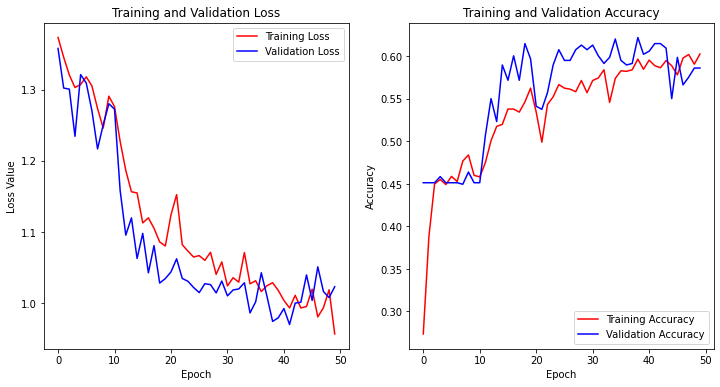

In [11]:
import matplotlib.pyplot as plt

trainLoss = model_history.history["loss"]
valLoss = model_history.history["val_loss"]
trainAccuracy = model_history.history["accuracy"]
valAccuracy = model_history.history["val_accuracy"]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(trainLoss, "r",label="Training Loss")
plt.plot(valLoss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(trainAccuracy, "r",label="Training Accuracy")
plt.plot(valAccuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Text(0.5, 1.0, 'ROC Curve')

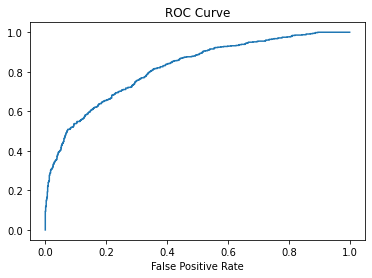

In [12]:
from sklearn.metrics import roc_curve

yPred = model.predict(xTest)

fpr, tpr, thresholds = roc_curve(yTest.ravel(),yPred.ravel())
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")